## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [20]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

## Exploring the data

In [21]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('/Users/rishabhsaha/Downloads/aclImdb/train')
test_ds = text_dataset_from_directory('/Users/rishabhsaha/Downloads/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 75000 files belonging to 3 classes.
Found 25000 files belonging to 2 classes.


In [22]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
55673,"Imagine a place between tuseday and purple - between the eighties and chest wigs. Now think back to Saphire and Steel, Deathwatch and certain episodes of Dr Who. Welcome... to Darkplace<br /><br /...",2
72576,"This is a sketch comedy movie done in the style of movie trailers. It's another in the long line of films that filled theaters in the mid to late 1970's like Kentucky Fried Movie, Groove Tube, Ame...",2
70306,"OK people, I'm not clueless. I love good movies and most of my top ten match the top ten of the majority of ""professional"" (i.e. they don't pay for their tickets OR their popcorn) critics but we p...",2
44887,"CRIME WAVE is a movie with much to offer. Although maybe over-titled in the sense there are only 4 criminals, it's still a solid story which is well directed, acted and photographed. This counts f...",2
13467,"Apart from being full of colors and sweet melody, the cinematic opera falls short of achieving that true great flavour that one has come to savour out of the classic Javanese Dance dramas and Rama...",2


In [23]:
print(dfTrain.loc[0, 'text'])

I've noticed a lot of people here made negative comments about this movie, but I don't see why. I really liked it. I always enjoyed reading Dennis the Menace comics and watching the cartoon in the 80s. I really thought the plot was interesting. I also liked how Dennis kept outsmarting that robber. It's really a good family movie with swear words or anything in this movie, (except for when Mr. Wilson says the abbreviation for 'gosh darn.'). I recommend for the people who disliked this movie to watch it again and give it another try.


## Tokenize the text

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 153845 unique tokens.


In [25]:
print(train_sequences[0])

[206, 2023, 3, 169, 4, 81, 133, 91, 1524, 796, 41, 11, 17, 18, 10, 89, 65, 134, 10, 64, 424, 9, 10, 212, 511, 888, 1760, 1, 4065, 3691, 2, 147, 1, 1096, 8, 1, 2154, 10, 64, 195, 1, 109, 13, 211, 10, 77, 424, 88, 1760, 793, 52020, 12, 9565, 43, 64, 3, 49, 237, 17, 15, 3954, 686, 39, 238, 8, 11, 17, 551, 16, 51, 475, 2594, 553, 1, 52021, 16, 68560, 5195, 833, 10, 390, 16, 1, 81, 34, 5686, 11, 17, 5, 105, 9, 173, 2, 198, 9, 154, 348]


In [26]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

["i've", 'noticed', 'a', 'lot', 'of', 'people', 'here', 'made', 'negative', 'comments', 'about', 'this', 'movie', 'but', 'i', "don't", 'see', 'why', 'i', 'really', 'liked', 'it', 'i', 'always', 'enjoyed', 'reading', 'dennis', 'the', 'menace', 'comics', 'and', 'watching', 'the', 'cartoon', 'in', 'the', '80s', 'i', 'really', 'thought', 'the', 'plot', 'was', 'interesting', 'i', 'also', 'liked', 'how', 'dennis', 'kept', 'outsmarting', 'that', 'robber', "it's", 'really', 'a', 'good', 'family', 'movie', 'with', 'swear', 'words', 'or', 'anything', 'in', 'this', 'movie', 'except', 'for', 'when', 'mr', 'wilson', 'says', 'the', 'abbreviation', 'for', "'gosh", 'darn', "'", 'i', 'recommend', 'for', 'the', 'people', 'who', 'disliked', 'this', 'movie', 'to', 'watch', 'it', 'again', 'and', 'give', 'it', 'another', 'try']


In [27]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [28]:
MAX_SEQUENCE_LENGTH

2493

In [29]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [30]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [31]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [32]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30

)

Epoch 1/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.1660 - loss: -3880.9443 - val_accuracy: 0.5000 - val_loss: 61192.0547
Epoch 2/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.1674 - loss: -125842.1172 - val_accuracy: 0.5000 - val_loss: 421120.3125
Epoch 3/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.1671 - loss: -595505.5000 - val_accuracy: 0.5000 - val_loss: 1198050.8750
Epoch 4/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.1672 - loss: -1520859.0000 - val_accuracy: 0.5000 - val_loss: 2452220.7500
Epoch 5/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.1665 - loss: -2901930.7500 - val_accuracy: 0.5000 - val_loss: 4250879.0000
Epoch 6/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.1678 - loss: -4841123.5000 - val_accuracy: 0.5000 - val_loss: 6639974.0000
Epoch 7/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 271s 231ms/step - accuracy: 0.1668 - loss: -7464861.0000 - val_accuracy: 0.5000 - val_loss: 9678

We used the countries.wiki model that was trained on the Wikipedia page on countries to create the word vectors. The accuracy obtained was approximately 50%. The problem here was that we trained our data on the Wikipedia pages on countries and applied it on the IMDB movie reviews; hence, the accuracy was approximately 50%. Now, let’s check whether we can solve the problem.


# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [34]:
glove_wiki = KeyedVectors.load_word2vec_format('/Users/rishabhsaha/Downloads/glove.6B/glove.6B.300d.txt', binary=False, no_header=True)

In [35]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [36]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=30
)

Epoch 1/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.1687 - loss: -16366.3994 - val_accuracy: 0.5000 - val_loss: 225598.0000
Epoch 2/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1419s 605ms/step - accuracy: 0.1649 - loss: -438738.7500 - val_accuracy: 0.5000 - val_loss: 1313669.5000
Epoch 3/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 475s 203ms/step - accuracy: 0.1664 - loss: -1800466.0000 - val_accuracy: 0.5000 - val_loss: 3552831.7500
Epoch 4/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1308s 558ms/step - accuracy: 0.1689 - loss: -4418808.5000 - val_accuracy: 0.5000 - val_loss: 7184224.0000
Epoch 5/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 751s 320ms/step - accuracy: 0.1667 - loss: -8580594.0000 - val_accuracy: 0.5000 - val_loss: 12500145.0000
Epoch 6/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1115s 476ms/step - accuracy: 0.1685 - loss: -14463093.0000 - val_accuracy: 0.5000 - val_loss: 19718378.0000
Epoch 7/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 519s 222ms/step - accuracy: 0.1684 - loss: -22135380.0000 - val_accuracy: 0.

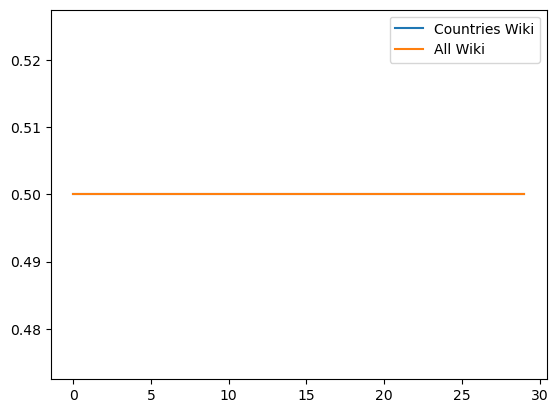

In [37]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()